# 한글폰트

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

Selecting previously unselected package fonts-nanum.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 11.1MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Tue May 11 10:11:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)

['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc']

In [ ]:
nsmc_dir = os.path.join(data_dir, "nsmc")
if not os.path.isdir(nsmc_dir):
    os.makedirs(nsmc_dir)
os.listdir(nsmc_dir)

# nsmc폴더 만들기 
# 만약 폴더 없으면 폴더 만들고
# list 보자

['nsmc.hdf5', 'nsmc.csv']

# Tutorial

# Tutorial

In [ ]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답
labels = [1, 0]  # 긍정(1), 부정(0)

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())
words

['나는', '오늘', '기분이', '좋아', '나는', '오늘', '우울해']

In [ ]:
# 중복 단어 제거
words = list(dict.fromkeys(words))
words

['나는', '오늘', '기분이', '좋아', '우울해']

In [ ]:
# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

word_to_id

{'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5}

In [ ]:
# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

# 거꾸로된거 다시 순서대로

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [ ]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

train_inputs

[[2, 3, 4, 5], [2, 3, 6]]

In [ ]:

# train label
train_labels = labels
train_labels

[1, 0]

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs:
    row += [0] * (4 - len(row))
train_inputs

[[2, 3, 4, 5], [2, 3, 6, 0]]

In [ ]:
# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)
train_inputs

array([[2, 3, 4, 5],
       [2, 3, 6, 0]])

In [ ]:
# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)

train_inputs, train_labels

(array([[2, 3, 4, 5],
        [2, 3, 6, 0]]), array([1, 0]))

In [ ]:
######################## 데이터 준비 완료 ############################

In [ ]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 3) # vocab 길이 = 7 , node = 3
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(2, 4, 3), dtype=float32, numpy=
array([[[ 0.00072207, -0.01411822,  0.02788493],
        [ 0.00853021,  0.02688133, -0.00167429],
        [ 0.00873896, -0.04772998, -0.00643448],
        [ 0.04782395,  0.04810704, -0.03535189]],

       [[ 0.00072207, -0.01411822,  0.02788493],
        [ 0.00853021,  0.02688133, -0.00167429],
        [ 0.04945729,  0.02813626, -0.02798697],
        [ 0.00380393, -0.01353813,  0.00816301]]], dtype=float32)>

In [ ]:
# weight 확인
weight, = embedding.get_weights()
weight.shape

(7, 3)

In [ ]:
# RNN, CNN

In [ ]:
# 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
pool = tf.keras.layers.GlobalMaxPool1D()
hidden_pool = pool(hidden)
hidden_pool

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.04782395, 0.04810704, 0.02788493],
       [0.04945729, 0.02813626, 0.02788493]], dtype=float32)>

In [ ]:
# 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
y_pred = linear(hidden_pool)
y_pred

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.517103  , 0.48289698],
       [0.5135102 , 0.48648977]], dtype=float32)>

In [ ]:
weight, bias = linear.get_weights()
weight.shape, bias.shape

((3, 2), (2,))

In [ ]:
# CE loss
tf.keras.losses.SparseCategoricalCrossentropy()(train_labels, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.69721866>

In [ ]:
# CE loss 직접 계산: y_true
y_true = tf.one_hot(train_labels, 2)
y_true

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 1.],
       [1., 0.]], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss1 = - y_true * tf.math.log(y_pred)
loss1

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.        , 0.72795194],
       [0.6664853 , 0.        ]], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss2 = tf.reduce_sum(loss1, axis=-1)
loss2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.72795194, 0.6664853 ], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss = tf.reduce_mean(loss2)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.69721866>

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args.n_out = 2
args

Namespace(d_model=32, n_out=2, n_vocab=7, seed=1234)

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((None,))

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs) # (batch_size , n_sequence, d_model)
    #
    # RNN, CNN, Attention, Linear
    #
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden) # (bs, d_model)
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden) # (bs, n_out)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

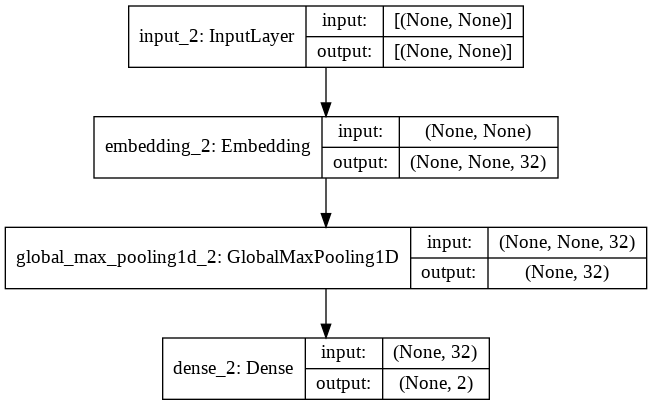

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs)

array([[0.49981168, 0.5001883 ],
       [0.49242312, 0.50757694]], dtype=float32)

# Vocabulary*

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

# Data*

In [ ]:
!wget https://github.com/e9t/nsmc/raw/master/ratings_train.txt
!wget https://github.com/e9t/nsmc/raw/master/ratings_test.txt

--2021-05-11 10:13:16--  https://github.com/e9t/nsmc/raw/master/ratings_train.txt
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt [following]
--2021-05-11 10:13:16--  https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14628807 (14M) [text/plain]
Saving to: ‘ratings_train.txt’

ratings_train.txt   100%[===================>]  13.95M  47.9MB/s    in 0.3s    

2021-05-11 10:13:16 (47.9 MB/s) - ‘ratings_train.txt’ saved [14628807/14628807]

--2021-05-11 10:13:16--  https://github.com/e9t/nsmc/raw/master

In [ ]:
id_to_label = {0: "부정", 1: "긍정"}

# EDA

In [ ]:
df_train = pd.read_csv('ratings_train.txt', delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


## char length

In [ ]:
# document 길이 데이터
train_length = df_train["document"].astype("str").apply(len)
train_length.head(5)

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

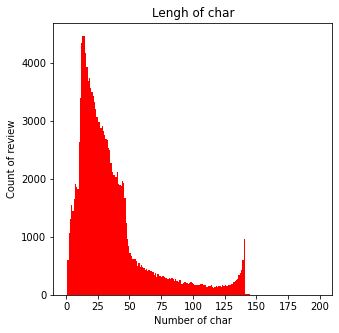

In [ ]:
plt.figure(figsize=(5,5))
plt.hist(train_length, bins=200, range=[0, 200], facecolor='r', label='char')
plt.title('Lengh of char')
plt.xlabel('Number of char')
plt.ylabel('Count of review')
plt.show()

# 대략 150에서 끝나고
# 25 단어수의 문장들이 대다수

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(train_length):4d}")
print(f"char 길이 최소:    {np.min(train_length):4d}")
print(f"char 길이 평균:    {np.mean(train_length):7.2f}")
print(f"char 길이 표준편차: {np.std(train_length):7.2f}")

char 길이 최대:     146
char 길이 최소:       1
char 길이 평균:      35.20
char 길이 표준편차:   29.53


In [ ]:
percentile25 = np.percentile(train_length, 25) # 25%
percentile50 = np.percentile(train_length, 50) # 50%
percentile75 = np.percentile(train_length, 75) # 75%
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5 # 81글자 이상은 outlier로 보자
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 25/100분위:    16.00
char 50/100분위:    27.00
char 75/100분위:    42.00
char IQR:          26.00
char MAX/100분위:   81.00


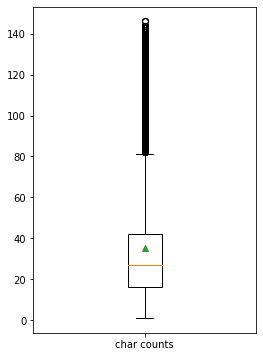

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['char counts'], showmeans=True)
plt.show()

# 박스 맨아래 0%
# 박스 아랫라인 25%
# 주황색 라인 중간값 27
# 초록색 평균값 35
# 박스 윗라인 75% 
# max/100
# Q3- Q2를 1.5배하고 그값을 다시 Q3에 더해서 그이상을 outlier로 보는것이 일반적

## word length

In [ ]:
# document 길이 데이터
train_length = df_train["document"].astype("str").apply(lambda x:len(x.split())) # 스플릿한 길이를
train_length.head(10)

0     5
1     4
2     1
3     6
4    11
5     8
6     4
7    13
8     6
9    10
Name: document, dtype: int64

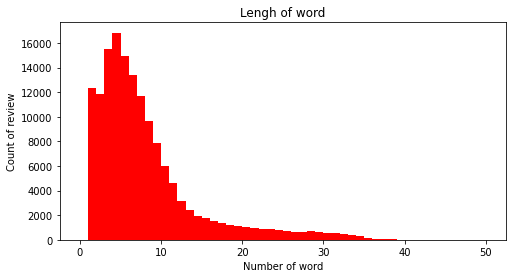

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=50, range=[0, 50], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(train_length):4d}")
print(f"word 길이 최소:    {np.min(train_length):4d}")
print(f"word 길이 평균:    {np.mean(train_length):7.2f}")
print(f"word 길이 표준편차: {np.std(train_length):7.2f}")

word 길이 최대:      41
word 길이 최소:       1
word 길이 평균:       7.58
word 길이 표준편차:    6.51


In [ ]:
# 100분위 지수로 봐보자

percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 25/100분위:     3.00
word 50/100분위:     6.00
word 75/100분위:     9.00
word IQR:           6.00
word MAX/100분위:   18.00


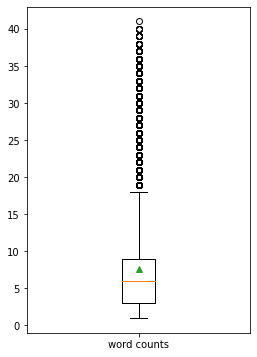

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['word counts'], showmeans=True)
plt.show()

## token length

In [ ]:
vocab.encode_as_pieces('안녕하세요 만나서 방가워용')

['▁안녕', '하', '세요', '▁만나', '서', '▁방', '가', '워', '용']

In [ ]:
# document 길이 데이터
train_length = df_train["document"].astype("str").apply(lambda x:len(vocab.encode_as_pieces(x)))# 이전 띄어쓰기가 아니라 sencente peace로 나눈 길이로 할거야
train_length.head(10)

# 음 아까 단어기준(띄어쓰기)로 한거보다 좀 값이 커졌네
# 띄어쓰기보단 많고 글자보단 적은 그 어딘가에 잇고

0    11
1    25
2    12
3    18
4    36
5    30
6    12
7    60
8    11
9    28
Name: document, dtype: int64

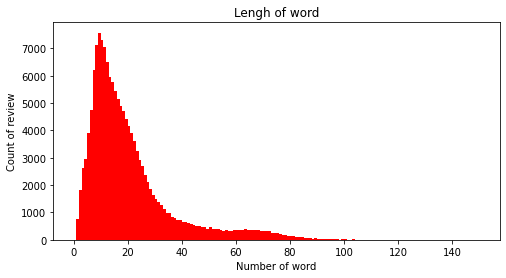

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=150, range=[0, 150], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

token 길이 최대:     140
token 길이 최소:       1
token 길이 평균:      20.08
token 길이 표준편차:   16.19


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

token 25/100분위:     9.00
token 50/100분위:    15.00
token 75/100분위:    24.00
token IQR:          15.00
token MAX/100분위:   46.50


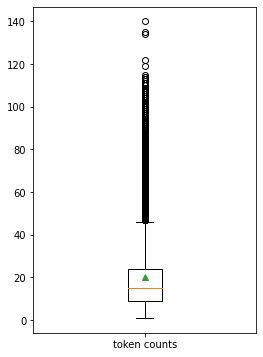

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['token counts'], showmeans=True)
plt.show()

## Label Count

In [ ]:
label_count = df_train['label'].value_counts()
label_count

0    75173
1    74827
Name: label, dtype: int64

In [ ]:
# label count
print(f"부정 리뷰 개수: {label_count[0]}")
print(f"긍정 리뷰 개수: {label_count[1]}")

부정 리뷰 개수: 75173
긍정 리뷰 개수: 74827


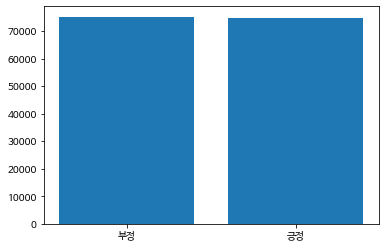

In [ ]:
# 한글 설정
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결
plt.bar(["부정", "긍정"], label_count)
plt.show()

## Word Cloud

In [ ]:
train_review = [review for review in df_train['document'] if type(review) is str]
train_review[:10]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?']

In [ ]:
from wordcloud import WordCloud

In [ ]:
" ".join(train_review[:10])

'아 더빙.. 진짜 짜증나네요 목소리 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 너무재밓었다그래서보는것을추천한다 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움. 원작의 긴장감을 제대로 살려내지못했다. 별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네 액션이 없는데도 재미 있는 몇안되는 영화 왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?'

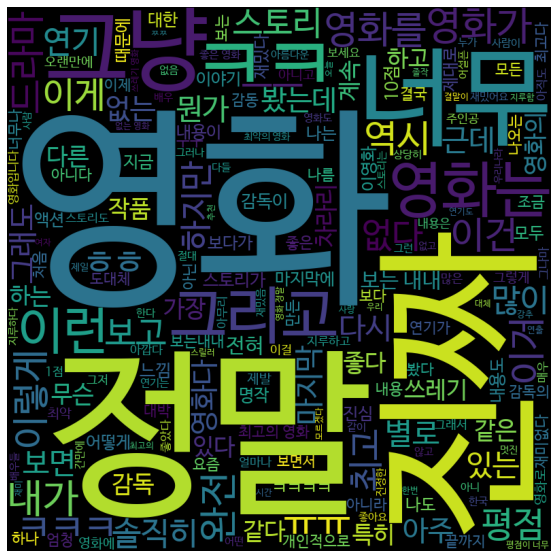

In [ ]:
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(train_review))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Small Data Project

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('ratings_train.txt', delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
df_train = df_train.sample(10)
df_train

,id,document,label
42986,9868530,공포 영화는 무슨...,0
25002,7745536,중심이 단단해야 이야기의 파급력도 커지는 법,0
104366,7951197,왜 공포스릴러에 코믹만 잔뜩들어간건데 근데 재미도없어,0
71235,6879284,인트로부터 결말까지하며 여운까지 완벽했던 애니메이션,1
118309,9441802,솔직히 시즌1이 전설이었지.,0
31809,8917151,참 할 말없게 만드네~~~ 몇십억대 집부터 이번에 캠핑카 까지~~ 한번 장볼때마다 ...,0
92264,9332061,옵대장과 나의 의리는 여기서부터 시작됬다,1
130960,9131754,그사람추기경을보러갔어요상영시작부터끝날때까지한순간도눈으뗄수가없고빠져들었습니다 우리나라...,1
113333,4673262,대박좋아요 너무잘만들었어요!,1
64882,9503750,영화가 점점 뒤로 갈수록 짜증나네~ㅋ,0


In [ ]:
df_test = pd.read_csv('ratings_test.txt', delimiter='\t')
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
df_test = df_test.sample(10)
df_test

,id,document,label
4994,1852644,장난? ㅋ,0
5743,7871316,처음 오프닝 부분에 동네 주민 인터뷰.. 경찰청 사람들의 형사들도 이보단 자연스러웠...,0
19252,6794224,오글오글 발연기 진리콧물흘리는 유노윤호모습이 떠오르네,0
16263,8515669,이 명작이 왜 7점밖에 안될까요? 평점만 보고 안보려고 했다가 안봤다면 후회할 뻔한...,1
48841,5352737,올 봄 당신들의 가슴속에 각인 될 단 하나의 똥쓰레기 작품이 온다 에어리언 대 거미,1
29056,7999154,11111111,1
31231,3950845,아~~재미없어~~~,0
27711,9962436,이 영화보고 울었다...,1
46728,10047874,리메이크 없나요 ... 아~ 또 보고싶다 극장에서 ..,1
28939,4896895,독특한 소재를 참 심심하게 만들어내는 능력이 있는 감독,0


In [ ]:
def make_data(df, vocab, n_seq):
    inputs, labels = [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        label = row["label"]
        document = row["document"]
        token = vocab.encode_as_ids(document)[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        print(label, len(token), token)
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(df_train, vocab, 47)
train_inputs, train_labels

0 47 [2880, 283, 12, 13402, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 47 [7777, 19529, 816, 954, 8, 522, 462, 842, 32, 10330, 12, 885, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 47 [3696, 2880, 97, 1144, 479, 14, 10956, 59, 2580, 30852, 6250, 365, 786, 379, 2083, 379, 16850, 32, 15358, 107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 47 [707, 160, 381, 24179, 145, 196, 770, 399, 145, 4970, 422, 1076, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 47 [25955, 127, 338, 136, 20, 19557, 32005, 44, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 47 [1562, 292, 237, 15358, 87, 595, 203, 377, 924, 924, 924, 763, 2399, 728, 76, 1016, 316, 12138, 11500, 3813, 321, 6816, 924, 92

(array([[ 2880,   283,    12, 13402,     7,     7,     7,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [ 7777, 19529,   816,   954,     8,   522,   462,   842,    32,
         10330,    12,   885,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [ 3696,  2880,    97,  1144,   479,    14, 10956,    59,  2580,
         30852,  6250,   365,   786,   379,  2083,   379, 16850,    32,
         15358,   107,     0,     0,     0,     0,     0,     0,     0,
             0, 

In [ ]:
test_inputs, test_labels = make_data(df_test, vocab, 47)
test_inputs, test_labels

0 47 [14214, 2138, 10, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0 47 [582, 12213, 6617, 14239, 4066, 6154, 7, 7, 15719, 1141, 8, 5521, 3037, 31, 191, 366, 907, 27717, 41, 7, 344, 10217, 37, 22357, 37, 200, 25041, 12, 764, 344, 1861, 273, 2493, 20, 20462, 12, 41, 7, 15875, 344, 1961, 157, 14164, 41, 6465, 7, 7]
0 47 [200, 2160, 179, 2160, 764, 344, 51, 8760, 27428, 562, 7062, 2576, 242, 201, 1454, 173, 297, 1959, 20, 11521, 377, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1 47 [31, 461, 917, 20, 3696, 77, 556, 4736, 298, 471, 3083, 506, 2138, 1537, 556, 59, 827, 11771, 3581, 166, 19, 298, 9582, 9648, 88, 163, 52, 11721, 33, 283, 12780, 377, 506, 7, 7, 8937, 884, 1523, 12994, 30, 1440, 842, 8095, 666, 6370, 7, 7]
1 47 [1589, 3251, 7288, 287, 5832, 6545, 346, 29, 1032, 488, 477, 8, 10, 19751, 1263, 332, 51, 7447, 13065, 4070, 10174, 235, 10, 16895, 0, 0, 0, 0, 0, 0,

(array([[14214,  2138,    10,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [  582, 12213,  6617, 14239,  4066,  6154,     7,     7, 15719,
          1141,     8,  5521,  3037,    31,   191,   366,   907, 27717,
            41,     7,   344, 10217,    37, 22357,    37,   200, 25041,
            12,   764,   344,  1861,   273,  2493,    20, 20462,    12,
            41,     7, 15875,   344,  1961,   157, 14164,    41,  6465,
             7,     7],
        [  200,  2160,   179,  2160,   764,   344,    51,  8760, 27428,
           562,  7062,  2576,   242,   201,  1454,   173,   297,  1959,
            20, 11521,   377,     0,     0,     0,     0,     0,     0,
             0, 

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256 # n의 dimension
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((None,)) # (bs, n_seq)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)
    #
    # RNN, CNN, Attention, Linear
    #
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden) # (bs, d_model)
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden) # (bs, out)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

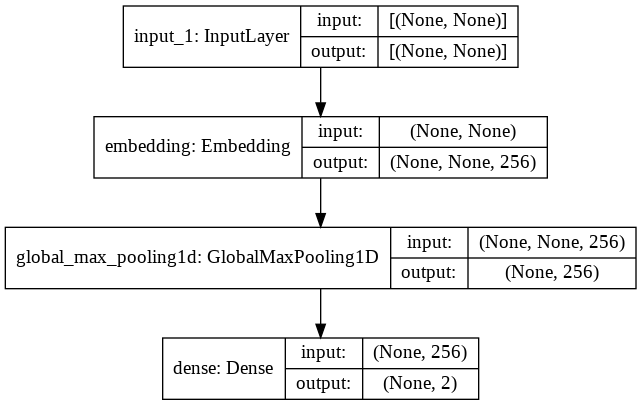

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 256)         8193792   
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 8,194,306
Trainable params: 8,194,306
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(train_inputs[:4])

array([[0.5441767 , 0.45582333],
       [0.5342777 , 0.46572232],
       [0.5407915 , 0.4592085 ],
       [0.5373849 , 0.46261504]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[0.53779846, 0.46220154],
       [0.5465347 , 0.4534653 ],
       [0.5478436 , 0.4521564 ],
       [0.5451488 , 0.45485124]], dtype=float32)

## Train

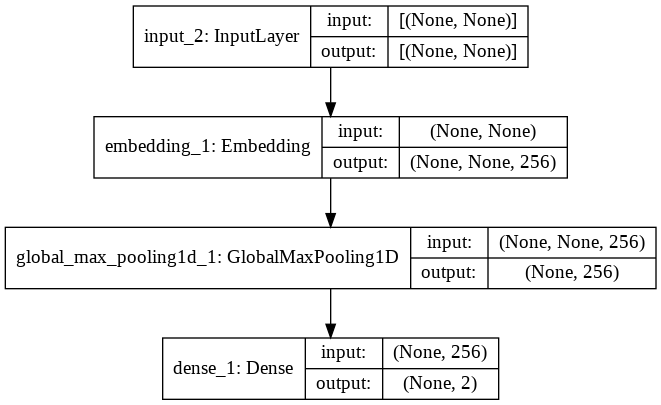

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, "nsmc.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, "nsmc.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=64,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
1/1 [==============================] - 1s 822ms/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc.hdf5
Epoch 2/100
1/1 [==============================] - 0s 135ms/step - loss: 0.6822 - accuracy: 0.6000 - val_loss: 0.6928 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.50000
Epoch 3/100
1/1 [==============================] - 0s 137ms/step - loss: 0.6704 - accuracy: 0.6000 - val_loss: 0.6933 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.50000
Epoch 4/100
1/1 [==============================] - 0s 124ms/step - loss: 0.6589 - accuracy: 0.6000 - val_loss: 0.6939 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/100
1/1 [==============================] - 0s 122ms/step - loss: 0.6480 - accuracy: 0.6000 - val_loss: 0.6946 - val

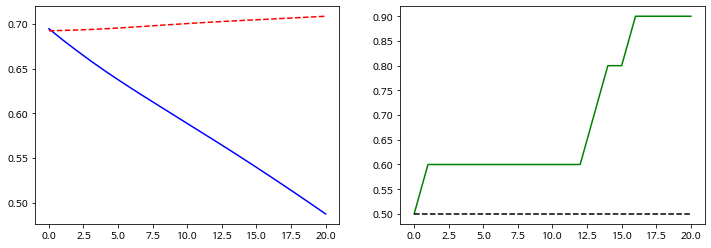

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(nsmc_dir, "nsmc.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 0s 191ms/step - loss: 0.6924 - accuracy: 0.5000


[0.6924363374710083, 0.5]

In [ ]:
y_pred = model.predict(test_inputs)
y_pred

# (긍정일 확률, 부정일 활률)

array([[0.51443523, 0.48556483],
       [0.5155581 , 0.48444185],
       [0.5147765 , 0.48522344],
       [0.516332  , 0.48366803],
       [0.5163791 , 0.4836209 ],
       [0.5008847 , 0.49911532],
       [0.5056552 , 0.49434483],
       [0.5088058 , 0.49119422],
       [0.51051044, 0.48948947],
       [0.5075232 , 0.4924768 ]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

# argmax는 큰값의 index를 출력하는거니까

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[5, 0],
       [5, 0]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1) # 0 이면 오류나니까 방어코드 하나 해둔거지 1로
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.5
precision: 0.0
recall: 0.0
f1: 0.0


## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(nsmc_dir, "nsmc.hdf5"))

In [ ]:
string = "영화 너무 심심해"

In [ ]:
vocab.encode_as_pieces(string)

['▁영화', '▁너무', '▁심', '심', '해']

In [ ]:
infer_input = vocab.encode_as_ids(string) # as ids로 바꿧네 ㅋㅋ # (n_seq)
infer_input = np.array([infer_input]) # (1, n_seq) 이떄 1은 batch_size//  문장이 하나이니까
infer_input

array([[ 283, 2364,  732,  690,   61]])

In [ ]:
train_inputs.shape, infer_input.shape

((10, 47), (1, 5))

In [ ]:
y_pred = model.predict(infer_input)
y_pred 

array([[0.51240385, 0.48759624]], dtype=float32)

In [ ]:
y_pred.shape

# batch_size = 1 
# 긍정 or 부정

(1, 2)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)[0]
y_class

0

In [ ]:
print(f"{string} : {id_to_label[y_class]}")

영화 너무 심심해 : 부정


In [ ]:
def do_predict(model, string):
    infer_input = vocab.encode_as_ids(string)
    infer_input = np.array([infer_input])

    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
do_predict(model, string)

'부정'

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 잉 기모뤙ㅋ
부정
input> 


# All Data Project

In [ ]:
df_train = pd.read_csv('ratings_train.txt', delimiter='\t')
df_test = pd.read_csv('ratings_test.txt', delimiter = '\t')

df_train = df_train.dropna()
df_test = df_test.dropna()


In [ ]:
def make_data(df, vocab, n_seq):
    inputs, labels = [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        label = row["label"] # columns 값 이름
        document = row["document"] # columns 값 이름
        token = vocab.encode_as_ids(document)[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        # print(label, len(token), token)
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(df_train, vocab, 50)

In [ ]:
test_inputs, test_labels = make_data(df_test,vocab, 50)

In [ ]:
len(vocab)
# vocab.shape


32007

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256 # n의 dimension
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((None,)) # (bs, n_seq)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)
    #
    # RNN, CNN, Attention, Linear
    lstm = tf.keras.layers.LSTM(128,return_sequences = True)
    hidden1 = lstm(hidden)
    lstm2 = tf.keras.layers.LSTM(64, return_sequences = True)
    hidden2 = lstm2(hidden1)
    #
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden2) # (bs, d_model)
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden) # (bs, out)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

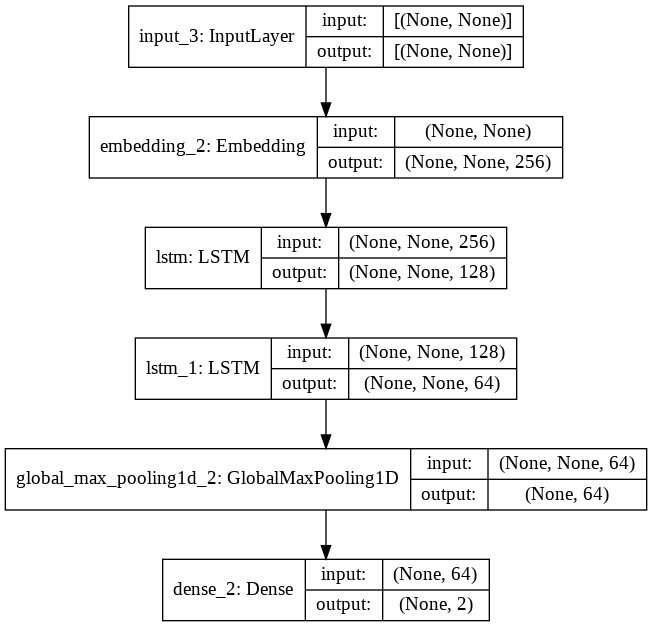

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, "nsmc.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, "nsmc.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=512,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
293/293 [==============================] - 82s 178ms/step - loss: 0.4748 - accuracy: 0.7719 - val_loss: 0.3594 - val_accuracy: 0.8422

Epoch 00001: val_accuracy improved from -inf to 0.84215, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc.hdf5
Epoch 2/100
293/293 [==============================] - 51s 173ms/step - loss: 0.3085 - accuracy: 0.8687 - val_loss: 0.3473 - val_accuracy: 0.8484

Epoch 00002: val_accuracy improved from 0.84215 to 0.84839, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc.hdf5
Epoch 3/100
293/293 [==============================] - 51s 175ms/step - loss: 0.2634 - accuracy: 0.8905 - val_loss: 0.3492 - val_accuracy: 0.8484

Epoch 00003: val_accuracy did not improve from 0.84839
Epoch 4/100
293/293 [==============================] - 50s 172ms/step - loss: 0.2266 - accuracy: 0.9085 - val_loss: 0.3656 - val_accuracy: 0.8466

Epoch 00004: val_accuracy did not improve from 0.84839
Epoch 5/100

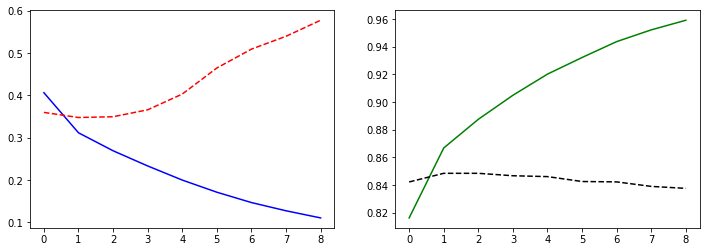

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(nsmc_dir, "nsmc.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

1563/1563 [==============================] - 20s 12ms/step - loss: 0.3457 - accuracy: 0.8486


[0.3473455309867859, 0.8483908772468567]

In [ ]:
y_pred = model.predict(test_inputs)
y_pred

# (긍정일 확률, 부정일 활률)

array([[0.1461191 , 0.8538809 ],
       [0.04291531, 0.9570847 ],
       [0.47019798, 0.529802  ],
       ...,
       [0.03754424, 0.9624558 ],
       [0.9966428 , 0.00335725],
       [0.6095685 , 0.3904315 ]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

# argmax는 큰값의 index를 출력하는거니까

array([1, 1, 1, ..., 1, 0, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[20986,  3840],
       [ 3740, 21431]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1) # 0 이면 오류나니까 방어코드 하나 해둔거지 1로
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.8483909034542072
precision: 0.8480471686913854
recall: 0.8514163124230265
f1: 0.8497284009357281


## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(nsmc_dir, "nsmc.hdf5"))

In [ ]:
string = "영화 너무 심심해"

In [ ]:
vocab.encode_as_pieces(string)

['▁영화', '▁너무', '▁심', '심', '해']

In [ ]:
infer_input = vocab.encode_as_ids(string) # as ids로 바꿧네 ㅋㅋ # (n_seq)
infer_input = np.array([infer_input]) # (1, n_seq) 이떄 1은 batch_size//  문장이 하나이니까
infer_input

array([[ 283, 2364,  732,  690,   61]])

In [ ]:
train_inputs.shape, infer_input.shape

((149995, 50), (1, 5))

In [ ]:
y_pred = model.predict(infer_input)
y_pred 

array([[0.7695257 , 0.23047434]], dtype=float32)

In [ ]:
y_pred.shape

# batch_size = 1 
# 긍정 or 부정

(1, 2)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)[0]
y_class

0

In [ ]:
print(f"{string} : {id_to_label[y_class]}")

영화 너무 심심해 : 부정


In [ ]:
def do_predict(model, string):
    infer_input = vocab.encode_as_ids(string)
    infer_input = np.array([infer_input])

    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
do_predict(model, string)

'부정'

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 


# Feature

In [ ]:
model = build_model(args) 

# model.load_weights(os.path.join(nsmc_dir,'nsmc.hdf5'))
# 학습 되지않은 weight로 load하면
# feature vector를 확인했을때 구분되지않은 상대로 dot이 찍히겠지



In [ ]:
feature_inputs = train_inputs[:1000]
feature_labels = train_labels[:1000]
feature_inputs, feature_labels

(array([[  199, 18033,     7, ...,     0,     0,     0],
        [15387,     7,     7, ...,     0,     0,     0],
        [ 2364,   358,     1, ...,     0,     0,     0],
        ...,
        [  325,  3735,   269, ...,     0,     0,     0],
        [   68,  1545,  4646, ...,     0,     0,     0],
        [ 1024,  2419,  8824, ...,  2083,   406,  2831]]),
 array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 256)         8193792   
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 8,440,450
Trainable params: 8,440,450
Non-trainable params: 0
_________________________________________________

In [ ]:
feature_input = model.input
feature_input

<KerasTensor: shape=(None, None) dtype=float32 (created by layer 'input_7')>

In [ ]:
feature_output = model.get_layer("global_max_pooling1d_6").output
feature_output

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'global_max_pooling1d_6')>

In [ ]:
feature_model = tf.keras.Model(inputs=feature_input, outputs=feature_output)

In [ ]:
y_feature = feature_model.predict(feature_inputs)
y_feature.shape

(1000, 64)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def plot_feature(feature, labels):
    plt.figure(figsize=(8, 8))
    
    f_pos = PCA(n_components=2).fit_transform(feature)
    
    for pos, label in zip(f_pos, labels):
        plt.scatter(pos[0], pos[1], color="green" if label == 0 else "orange")
    
    plt.show()

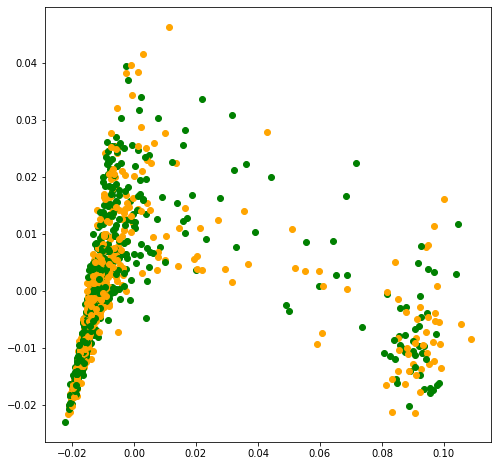

In [ ]:
plot_feature(y_feature, feature_labels)

# 학습 전

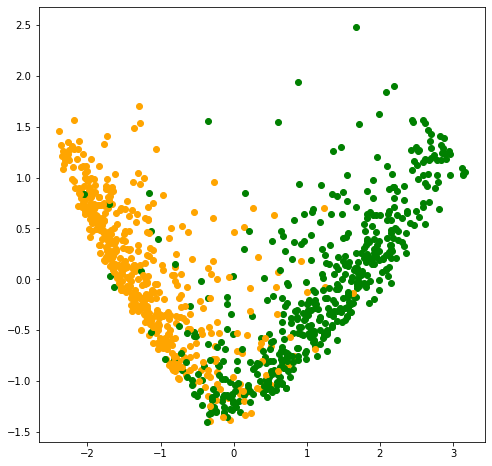

In [ ]:
plot_feature(y_feature, feature_labels)

# 학습후

# Gensim

## Gensim Training

In [ ]:
df_train = pd.read_csv('ratings_train.txt', delimiter='\t')
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
df_test = pd.read_csv('ratings_test.txt', delimiter='\t')
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
tokens = []

for i, row in tqdm(df_train.iterrows(), total=len(df_train)):
    document = row["document"]
    token = vocab.encode_as_pieces(document)
    tokens.append(token)

for i, row in tqdm(df_test.iterrows(), total=len(df_test)):
    document = row["document"]
    token = vocab.encode_as_pieces(document)
    tokens.append(token)

len(tokens)

# gensim을 학습시키기 위해서 tokenize한거임
# word 2 vec을 적용시켜보려구

199992

In [ ]:
import gensim

In [ ]:
fastText = gensim.models.FastText(sentences=tokens, size=128, window=5, min_count=1)

In [ ]:
fastText.wv["_대한민국"]

array([-0.126743  , -0.06909529,  0.22321182,  0.41454974, -0.4663261 ,
        0.65620565,  0.01270351,  0.34158897, -0.599112  , -0.37759253,
       -0.02208096,  0.13877408,  0.10197154, -0.4186678 , -0.125539  ,
        0.00602201, -0.09576452,  0.0516635 , -0.21751173,  0.45844984,
        0.35167947,  0.16155148, -0.34170306,  0.22737765,  0.395988  ,
        0.6030198 ,  0.2532496 , -0.33940473, -0.17799556, -0.11183374,
       -0.34256425,  0.27786615, -0.32761955,  0.42117497, -0.2915266 ,
        0.02607768,  0.583107  ,  0.07436971,  0.2666087 ,  0.05953695,
        0.46744218,  0.22808413,  0.15817346, -0.41619053,  0.39943072,
       -0.5242371 , -0.42615184,  0.24518813,  0.50511056,  0.09101307,
        0.25973532, -0.21762104, -0.3350606 ,  0.22732103, -0.24473895,
       -0.09403238, -0.12580611, -0.15095334, -0.5894179 , -0.3015616 ,
       -0.09969012,  0.65934   , -0.39582267, -0.04682565,  0.34417173,
        0.01320548,  0.17882401,  0.39170572, -0.43117866, -0.61

In [ ]:
embedding = tf.keras.layers.Embedding(len(vocab), 128)
embedding(0)
tf_weight = embedding.get_weights()[0]
np.linalg.norm(tf_weight, axis=-1)

# embedding값이 확실히 작네!
# norm 은 크기!

array([0.34299868, 0.34940308, 0.33115137, ..., 0.34066564, 0.33950564,
       0.3346498 ], dtype=float32)

In [ ]:
np_weight = np.random.randn(len(vocab), 128)
np.linalg.norm(np_weight, axis=-1)

array([10.75353015, 11.3931744 , 11.80833113, ..., 12.14955266,
       10.84963573, 11.00401228])

In [ ]:
gensim_weight = np.random.randn(len(vocab), 128)
oov = 0
for i in range(len(vocab)):
    token = vocab.id_to_piece(i)
    # print(i,token)
    if token in fastText.wv:
        gensim_weight[i] = fastText.wv[token] # i 번째에 weight를 넣어주어라!
    else:
        oov += 1
    # if 100 < i:
    #     break
oov

# 2402의 out of vocab이 있따는거지

2402

In [ ]:
norm = np.linalg.norm(gensim_weight, axis=-1)
norm

# 이때 norm값이 embedding에 비해서 값이 높으니까 normalize해야겠다


array([11.08360515,  0.72390778, 11.34092592, ...,  0.37813176,
       29.03497375,  0.35726884])

In [ ]:
gensim_weight /= (np.expand_dims(norm, 1) * 2.1) # 차원 맞춰야되니까 확장!
gensim_weight

array([[-0.03686139,  0.06194532,  0.00769624, ...,  0.03757098,
         0.04587094,  0.00784662],
       [-0.04807246, -0.07175747, -0.01959423, ...,  0.07621439,
         0.0083958 , -0.00142295],
       [ 0.0186914 ,  0.01363532, -0.04370469, ...,  0.02209247,
         0.02382047,  0.00137188],
       ...,
       [ 0.00119865, -0.08406451,  0.03500307, ...,  0.02997732,
        -0.04335778,  0.04054923],
       [ 0.04760852, -0.0316507 , -0.00714982, ..., -0.04080906,
         0.02954146,  0.00089771],
       [ 0.04777413, -0.04303083,  0.01068384, ...,  0.03390707,
        -0.04535678,  0.05909786]])

In [ ]:
np.linalg.norm(gensim_weight, axis=-1)

# 즉 젠심에서 학습한 범위와
# tensorflow가 학습한 범위와
# pytorch에서 학습한 범위가  다를수 있으니 
# 맞춰주어야 한다

array([0.47619048, 0.47619048, 0.47619048, ..., 0.47619048, 0.47619048,
       0.47619048])

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('ratings_train.txt', delimiter='\t')
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
df_test = pd.read_csv('ratings_test.txt', delimiter='\t')
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
def make_data(df, vocab, n_seq):
    inputs, labels = [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        label = row["label"]
        document = row["document"]
        token = vocab.encode_as_ids(document)[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(df_train, vocab, 47)
train_inputs, train_labels

(array([[  199, 18033,     7, ...,     0,     0,     0],
        [15387,     7,     7, ...,     0,     0,     0],
        [ 2364,   358,     1, ...,     0,     0,     0],
        ...,
        [   31,    87, 21397, ...,     0,     0,     0],
        [13688,  6278, 24814, ...,     0,     0,     0],
        [  259,   283,   832, ...,     0,     0,     0]]),
 array([0, 1, 0, ..., 0, 1, 0]))

In [ ]:
test_inputs, test_labels = make_data(df_test, vocab, 47)
test_inputs, test_labels

(array([[   10, 31940,    10, ...,     0,     0,     0],
        [  805,   511,   927, ...,     0,     0,     0],
        [21397,   187,    31, ...,     0,     0,     0],
        ...,
        [ 1777,    32, 20937, ...,     0,     0,     0],
        [ 3828, 27298,    12, ...,     0,     0,     0],
        [ 3715,    12,   345, ...,     0,     0,     0]]),
 array([1, 0, 0, ..., 0, 0, 0]))

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 128
args.n_out = 2
args

Namespace(d_model=128, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_gensim_model(args, weights=None): # 이번엔 옵션을 더 넣었지/ weight를 줄수도있고 안줄수도잇고
    inputs = tf.keras.layers.Input((None,))

    if weights is not None:
        print('initialize embedding with input !!!')
        embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model, weights=[weights])
    else:
        embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)
    #
    # RNN, CNN, Attention, Linear

    lstm1 = tf.keras.layers.LSTM(units=256 , return_sequences = True)
    hidden = lstm1(hidden)
    lstm2 = tf.keras.layers.LSTM(units = 128, return_sequences = True)
    hidden = lstm2(hidden)
    #
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden)
    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model


    # 모든 weight를 gensim 으로
    # 없는 경우에는 아까 임의로 만든 weight로 + 임의로 만들었으면 norm까지 normalize해서 맞춰줘야지

initialize embedding with input !!!


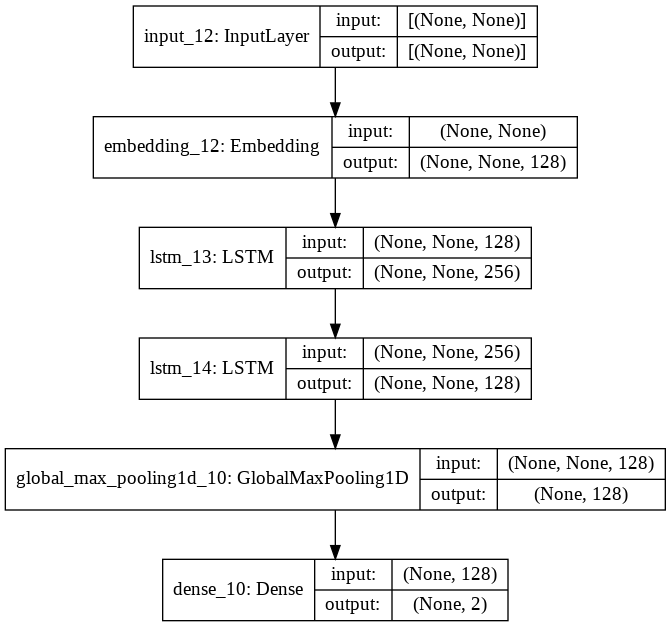

In [ ]:
model = build_gensim_model(args, gensim_weight)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs[:4])

array([[0.5020841 , 0.49791595],
       [0.5007767 , 0.49922326],
       [0.5035263 , 0.49647373],
       [0.50245386, 0.49754614]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[0.5039564 , 0.49604362],
       [0.500847  , 0.49915302],
       [0.4984651 , 0.5015349 ],
       [0.5003889 , 0.49961108]], dtype=float32)

## Train

initialize embedding with input !!!


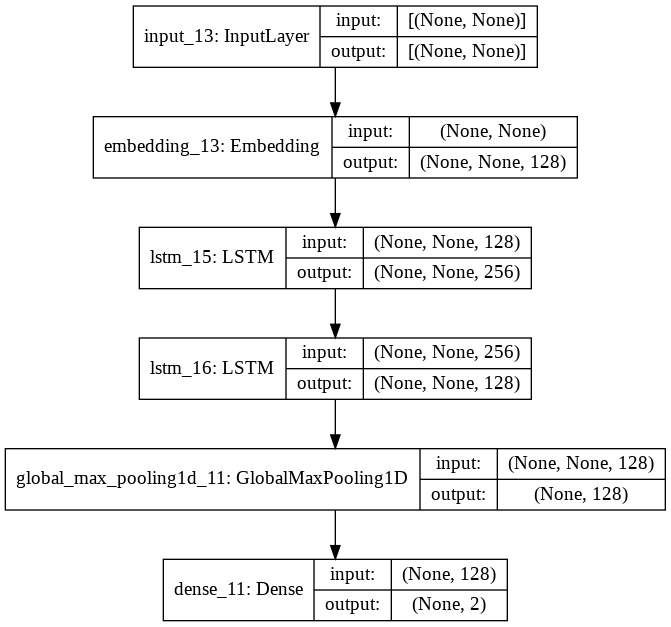

In [ ]:
model = build_gensim_model(args, gensim_weight)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, "nsmc_gemsim.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, "nsmc.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=10,
                    batch_size=512,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/10
293/293 [==============================] - 42s 134ms/step - loss: 0.4672 - accuracy: 0.7826 - val_loss: 0.3574 - val_accuracy: 0.8429

Epoch 00001: val_accuracy improved from -inf to 0.84291, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc_gemsim.hdf5
Epoch 2/10
293/293 [==============================] - 38s 130ms/step - loss: 0.3131 - accuracy: 0.8671 - val_loss: 0.3412 - val_accuracy: 0.8503

Epoch 00002: val_accuracy improved from 0.84291 to 0.85027, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc_gemsim.hdf5
Epoch 3/10
293/293 [==============================] - 38s 130ms/step - loss: 0.2692 - accuracy: 0.8880 - val_loss: 0.3446 - val_accuracy: 0.8520

Epoch 00003: val_accuracy improved from 0.85027 to 0.85195, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc_gemsim.hdf5
Epoch 4/10
293/293 [==============================] - 38s 130ms/step - loss: 0.2343 - accuracy: 0.9054 

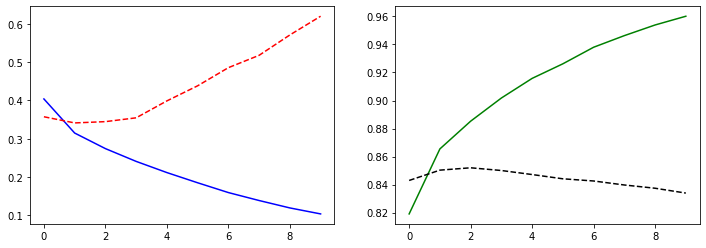

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_gensim_model(args)
model.load_weights(os.path.join(nsmc_dir, "nsmc_gemsim.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

1563/1563 [==============================] - 24s 14ms/step - loss: 0.3447 - accuracy: 0.8521


[0.3446284532546997, 0.8519511222839355]

In [ ]:
y_pred = model.predict(test_inputs)
y_pred

array([[0.08364149, 0.91635853],
       [0.0533283 , 0.9466718 ],
       [0.5082497 , 0.4917503 ],
       ...,
       [0.08823369, 0.9117663 ],
       [0.99192786, 0.00807212],
       [0.64936817, 0.3506318 ]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1, 1, 0, ..., 1, 0, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[20950,  3876],
       [ 3526, 21645]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.851951117067024
precision: 0.848125073468908
recall: 0.8599181597870565
f1: 0.8539809042846997


## 배포

In [ ]:
model = build_gensim_model(args)
model.load_weights(os.path.join(nsmc_dir, "nsmc_gemsim.hdf5"))

In [ ]:
def do_predict(model, string):
    infer_input = vocab.encode_as_ids(string)
    infer_input = np.array([infer_input])

    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 


# Yoon Kim

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('ratings_train.txt', delimiter='\t')
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
df_train = df_train.dropna()
df_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
df_test = pd.read_csv('ratings_test.txt', delimiter='\t')
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
df_test = df_test.dropna()
df_test

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [ ]:
def make_data(df, vocab, n_seq):
    inputs, labels = [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        label = row["label"]
        document = row["document"]
        token = vocab.encode_as_ids(document)[:n_seq]
        token = token + [0] * (n_seq - len(token))
        assert len(token) == n_seq
        inputs.append(token)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(df_train, vocab, 47)
train_inputs, train_labels

(array([[  199, 18033,     7, ...,     0,     0,     0],
        [15387,     7,     7, ...,     0,     0,     0],
        [ 2364,   358,     1, ...,     0,     0,     0],
        ...,
        [   31,    87, 21397, ...,     0,     0,     0],
        [13688,  6278, 24814, ...,     0,     0,     0],
        [  259,   283,   832, ...,     0,     0,     0]]),
 array([0, 1, 0, ..., 0, 1, 0]))

In [ ]:
test_inputs, test_labels = make_data(df_test, vocab, 47)
test_inputs, test_labels

(array([[   10, 31940,    10, ...,     0,     0,     0],
        [  805,   511,   927, ...,     0,     0,     0],
        [21397,   187,    31, ...,     0,     0,     0],
        ...,
        [ 1777,    32, 20937, ...,     0,     0,     0],
        [ 3828, 27298,    12, ...,     0,     0,     0],
        [ 3715,    12,   345, ...,     0,     0,     0]]),
 array([1, 0, 0, ..., 0, 0, 0]))

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 128
args.n_out = 2
args

Namespace(d_model=128, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model(args):
    inputs = tf.keras.layers.Input((None,))

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)

    ########################################################
    # conv3, conv4, conv5
    hidden1 = tf.keras.layers.Conv1D( filters = 128, kernel_size = 3, padding = 'causal')(hidden) # batchsize, n_seq, 128
    hidden1 = tf.keras.layers.Dropout(0.5)(hidden1)

    hidden2 = tf.keras.layers.Conv1D( filters = 128, kernel_size = 4, padding = 'causal')(hidden)
    hidden2 = tf.keras.layers.Dropout(0.5)(hidden2)

    hidden3 = tf.keras.layers.Conv1D( filters = 128, kernel_size = 5, padding = 'causal')(hidden)
    hidden3 = tf.keras.layers.Dropout(0.5)(hidden3)

    # plooling
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden1 = pool(hidden1)
    hidden2 = pool(hidden2) # (batchsize, 128)
    hidden3 = pool(hidden3)
    
    # concat

    hidden = tf.concat([hidden1, hidden2, hidden3], axis = 1)
    ########################################################

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=y_pred)
    return model

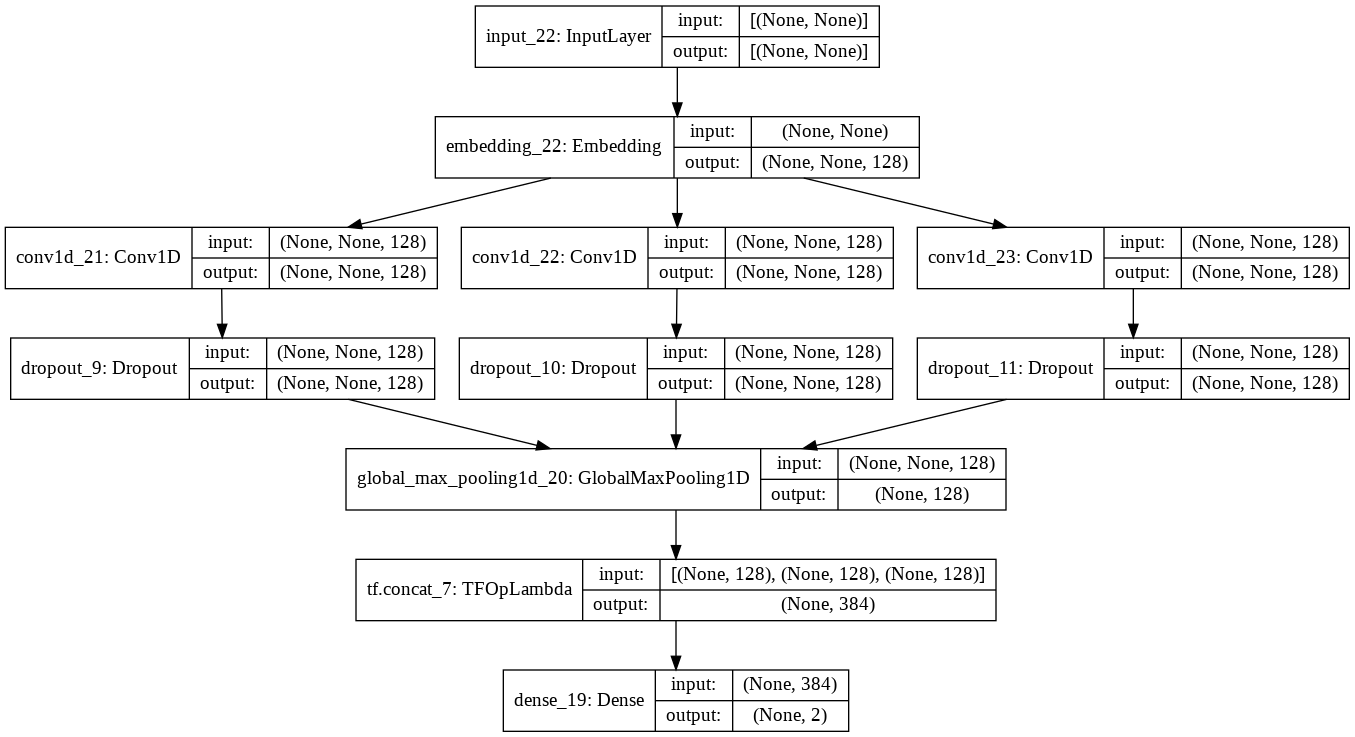

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict(train_inputs[:4])

array([[0.47872278, 0.52127725],
       [0.47922924, 0.5207707 ],
       [0.4812848 , 0.5187152 ],
       [0.49358556, 0.5064145 ]], dtype=float32)

In [ ]:
model.predict(test_inputs[:4])

array([[0.48146865, 0.5185313 ],
       [0.47586435, 0.5241356 ],
       [0.4865155 , 0.5134845 ],
       [0.47011682, 0.52988315]], dtype=float32)

## Train

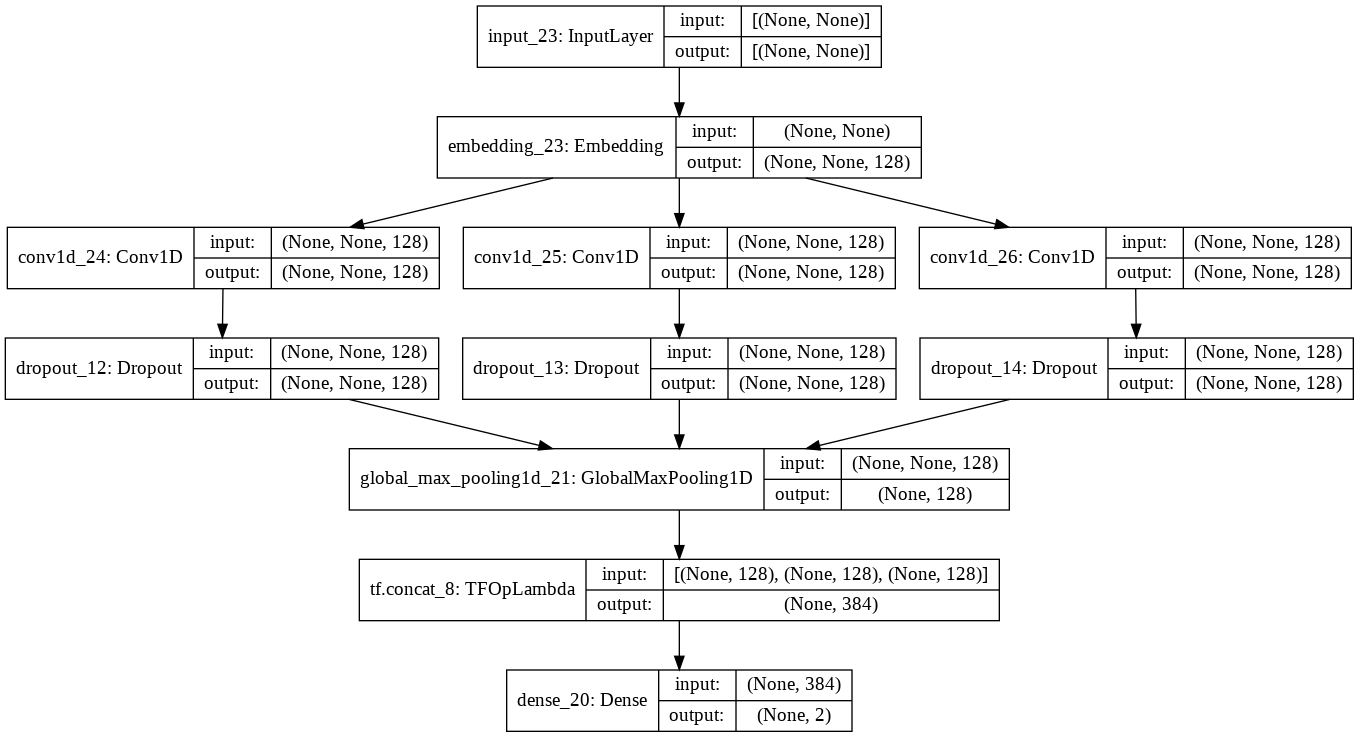

In [ ]:
model = build_model(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, "nsmc_yoonkim.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, "nsmc.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=10,
                    batch_size=512,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/10
293/293 [==============================] - 33s 108ms/step - loss: 0.4742 - accuracy: 0.7678 - val_loss: 0.3763 - val_accuracy: 0.8500

Epoch 00001: val_accuracy improved from -inf to 0.85003, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc_yoonkim.hdf5
Epoch 2/10
293/293 [==============================] - 26s 90ms/step - loss: 0.2967 - accuracy: 0.8773 - val_loss: 0.3522 - val_accuracy: 0.8556

Epoch 00002: val_accuracy improved from 0.85003 to 0.85555, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc_yoonkim.hdf5
Epoch 3/10
293/293 [==============================] - 25s 87ms/step - loss: 0.2419 - accuracy: 0.9053 - val_loss: 0.3396 - val_accuracy: 0.8583

Epoch 00003: val_accuracy improved from 0.85555 to 0.85829, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/nsmc/nsmc_yoonkim.hdf5
Epoch 4/10
293/293 [==============================] - 27s 92ms/step - loss: 0.1914 - accuracy: 0.9297 

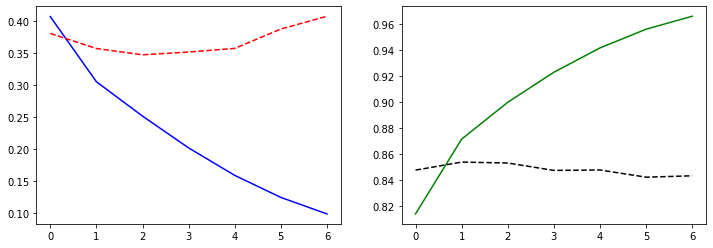

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(nsmc_dir, "nsmc_yoonkim.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

1563/1563 [==============================] - 7s 4ms/step - loss: 0.3393 - accuracy: 0.8595


[0.33964625000953674, 0.858291506767273]

In [ ]:
y_pred = model.predict(test_inputs)
y_pred

array([[0.18619223, 0.8138077 ],
       [0.6736762 , 0.3263238 ],
       [0.11602894, 0.8839711 ],
       ...,
       [0.08002889, 0.91997117],
       [0.9823836 , 0.01761645],
       [0.5515624 , 0.44843757]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1, 0, 1, ..., 1, 0, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[20936,  3890],
       [ 3195, 21976]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.8582914974898493
precision: 0.8496095260187119
recall: 0.8730682134202058
f1: 0.8611791445421949


## 배포

In [ ]:
model = build_model(args)
model.load_weights(os.path.join(nsmc_dir, "nsmc_yoonkim.hdf5"))

In [ ]:
def do_predict(model, string):
    infer_input = vocab.encode_as_ids(string)
    infer_input = np.array([infer_input])

    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
while True:
    print("input> ", end="")
    string = str(input())
    if len(string) == 0:
        break
    result = do_predict(model, string)
    print(result)

input> 
